In [1]:
import torch
import joblib
import pandas as pd
import numpy as np
import gzip
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'mps'

In [2]:
# Load the trained model and scaler
model_path = '../Data/Model/bert_mlp_10fold_model.pth.gz'
scaler_path = '../Data/Model/bert_10fold_scaler.pkl.gz'

model = torch.load(model_path)
model.to(device)
model.eval()

# 加载标准化器
with gzip.open(scaler_path, 'rb') as f:
    scaler = joblib.load(f)

def preprocess_data(new_data):
    # 将列表转换为NumPy数组
    new_data_array = np.array(new_data)
    # 使用加载的标准化器转换数据
    new_data_scaled = scaler.transform(new_data_array)
    return new_data_scaled

# 定义用于分类新数据的函数
def classify_new_data(new_data):
    preprocessed_data = preprocess_data(new_data)
    preprocessed_data_tensor = torch.tensor(preprocessed_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        predictions = model(preprocessed_data_tensor)
    # 将预测概率转换为0或1
    predictions = (predictions > 0.5).float()
    return predictions.cpu().numpy()

In [3]:
breeze_data_df = pd.read_csv('../Data/breeze_bert_vector.csv')
breeze_data_df

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v759,v760,v761,v762,v763,v764,v765,v766,v767,source
0,0.467858,-0.139868,-0.574200,0.172832,-0.290886,-0.560038,0.265498,0.473457,-0.383780,-0.216966,...,-0.398964,0.081079,0.223415,-0.034241,0.041519,-0.432376,0.442163,-0.090937,0.265284,breeze
1,0.704071,0.064624,-0.371531,0.104917,-0.172033,-0.409153,-0.042752,0.453261,-0.253223,-0.344273,...,-0.340942,0.151568,0.163683,-0.243190,-0.039085,-0.272758,0.541151,0.096704,0.331410,breeze
2,0.646771,-0.025249,-0.694986,0.236292,-0.240382,-0.487850,0.146030,0.328960,-0.135261,-0.416314,...,-0.356927,0.100235,0.223953,0.066387,0.105494,-0.252533,0.497889,0.053042,0.364454,breeze
3,0.604633,-0.150303,-0.586229,0.209180,-0.212596,-0.448794,0.083869,0.338488,-0.315691,-0.431810,...,-0.324099,0.179676,0.194631,-0.005615,0.057602,-0.427592,0.335587,0.085985,0.419875,breeze
4,0.571138,-0.037650,-0.619187,0.197687,-0.187070,-0.452016,0.187546,0.618210,-0.425271,-0.299948,...,-0.459651,0.226328,0.077382,-0.273533,-0.007868,-0.419683,0.624898,0.149911,0.205660,breeze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,0.458619,-0.135518,-0.456867,0.167298,-0.261456,-0.417972,0.282640,0.429110,-0.373968,-0.416567,...,-0.275062,0.089154,0.128851,-0.027526,0.122372,-0.550465,0.456207,0.073818,0.271970,breeze
1003,0.528032,-0.014417,-0.427911,0.123013,-0.182197,-0.396405,-0.034938,0.414540,-0.372423,-0.386158,...,-0.347654,0.256193,0.172021,-0.177273,0.155389,-0.366900,0.502487,0.036055,0.219508,breeze
1004,0.414922,-0.103974,-0.620031,0.203850,-0.238266,-0.297512,0.155757,0.545714,-0.379862,-0.346390,...,-0.385866,-0.054145,0.189242,-0.221129,0.224842,-0.174587,0.607356,0.191946,0.269353,breeze
1005,0.524107,0.116666,-0.609483,0.150351,-0.265906,-0.292106,0.121498,0.511075,-0.269205,-0.168108,...,-0.399636,0.116639,0.084894,-0.357924,0.070913,-0.402378,0.301207,0.070834,0.385322,breeze


Accuracy: 0.8222


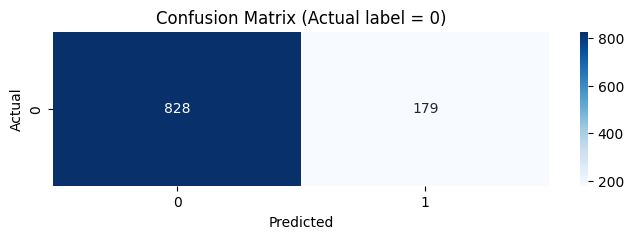

In [4]:
new_data = breeze_data_df.iloc[:, :-1].values
predictions = classify_new_data(new_data)

# 假设所有新数据的真实标签都是0
true_labels = np.zeros(len(new_data))

# 计算精确度、召回率和准确率
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 只保留实际标签为0的部分
cm_actual_0 = cm[0].reshape(1, -1)

# 绘制部分混淆矩阵
plt.figure(figsize=(8, 2))
sns.heatmap(cm_actual_0, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0'])
plt.title('Confusion Matrix (Actual label = 0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()